<a href="https://colab.research.google.com/github/aimazin/Stock_predictions/blob/main/aapljun2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Return Prediction and the Knowledge of When to Strike

## Business Question and Approach

The tasks:
    
    1.) inspect what indicators to build a percentage 5 day return model with
    
    2.) find a good preditive model
    
    3.) find a characterisation for the indicators state to find out when to buy/strike
    
    4.) evaluate 1.), 2.), and 3.) through visualizations

In [3]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
!cd build
!cmake ./LightGBM
!make -j4

Cloning into 'LightGBM'...
remote: Enumerating objects: 26307, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 26307 (delta 48), reused 81 (delta 28), pack-reused 26195
Receiving objects: 100% (26307/26307), 19.13 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (19425/19425), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Compres

In [4]:
 
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-06-19 17:49:57--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-06-19 17:49:57--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-06-19 17:49:57--  http://versaweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving versaweb.dl.s

In [5]:
! pip install xgboost
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 46.6 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Ingestion of Data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, Normalizer
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor as rfr, VotingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor 
import yfinance as yf
import datetime
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
plt.style.use('fivethirtyeight')

In [162]:
aapl = yf.Ticker('AAPL')
aapl = aapl.history(start="2022-01-04", end="2022-06-11", interval="1d")


## Exploration of Data

In [163]:
aapl.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,110.000000,110.000000,110.000000,110.000000,1.100000e+02,110.000000,110.0
mean,162.277567,164.477168,159.916284,162.180514,9.536804e+07,0.004091,0.0
std,10.982683,10.590887,11.196947,10.942329,2.334313e+07,0.030207,0.0
min,137.389999,140.699997,132.610001,137.130005,5.395020e+07,0.000000,0.0
25%,155.763448,159.144739,153.328849,156.390228,7.887978e+07,0.000000,0.0
50%,164.198751,166.295667,161.887142,164.343544,9.091130e+07,0.000000,0.0
75%,171.007564,173.100670,169.750600,171.668468,1.050397e+08,0.000000,0.0
max,182.130025,182.439174,178.629624,179.208038,1.826020e+08,0.230000,0.0


In [164]:
aapl.head(10)
aapl.drop('Stock Splits', axis=1, inplace=True)

## Creating Indicators and targets from data

In [165]:

bx = aapl.iloc[:,5].values.astype(float)
tx = aapl.iloc[:,1].values.astype(float)
cx = aapl.iloc[:,2].values.astype(float)
bix = aapl.iloc[:,4].values.astype(float)

### the indicators


In [166]:
 #create bbands indicators
#btci["upperband"], btci["middleband"], btci["lowerband"] = talib.BBANDS(bx, timeperiod=8, nbdevup=2, nbdevdn=2, matype=0)

#create the SMA indicator
#btci['max' + str(8)] = talib.SMA(bx,timeperiod=8) / bx

feature_names = []  # a list of the feature names for 

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [10]:
    # Create the RSI indicator
    aapl['rsix' + str(n)] = talib.RSI(bx, timeperiod=n)
    
    # Create the CCI indicator
    aapl['ccix' + str(n)] = talib.CCI(tx,cx,bx, timeperiod=n)
    
    # Create the MFI indicator
    aapl['mfix' + str(n)] = talib.MFI(tx , cx, bx, bix, timeperiod=n)

    # Create bbands indicators
    aapl["upperband"+str(n)], aapl["middleband"+str(n)], aapl["lowerband"+str(n)] = talib.BBANDS(bx, timeperiod=n, nbdevup=2, nbdevdn=2, matype=0)
    
   
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['max' + str(n), 'rsix' + str(n)
                                     , 'ccix' + str(n), 'mfix' + str(n)]

print(feature_names)

['max10', 'rsix10', 'ccix10', 'mfix10']


### the target (cumulative percentage 5 day return)

In [167]:
aapl['5cum_pct']= (aapl['Close'].pct_change(5)).cumsum()

In [168]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110 entries, 2022-01-04 to 2022-06-10
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          110 non-null    float64
 1   High          110 non-null    float64
 2   Low           110 non-null    float64
 3   Close         110 non-null    float64
 4   Volume        110 non-null    int64  
 5   Dividends     110 non-null    float64
 6   rsix10        100 non-null    float64
 7   ccix10        101 non-null    float64
 8   mfix10        100 non-null    float64
 9   upperband10   101 non-null    float64
 10  middleband10  101 non-null    float64
 11  lowerband10   101 non-null    float64
 12  5cum_pct      105 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 12.0 KB


## Evaluating indicators with target

In [169]:
corr = aapl.corr()


<function matplotlib.pyplot.show>

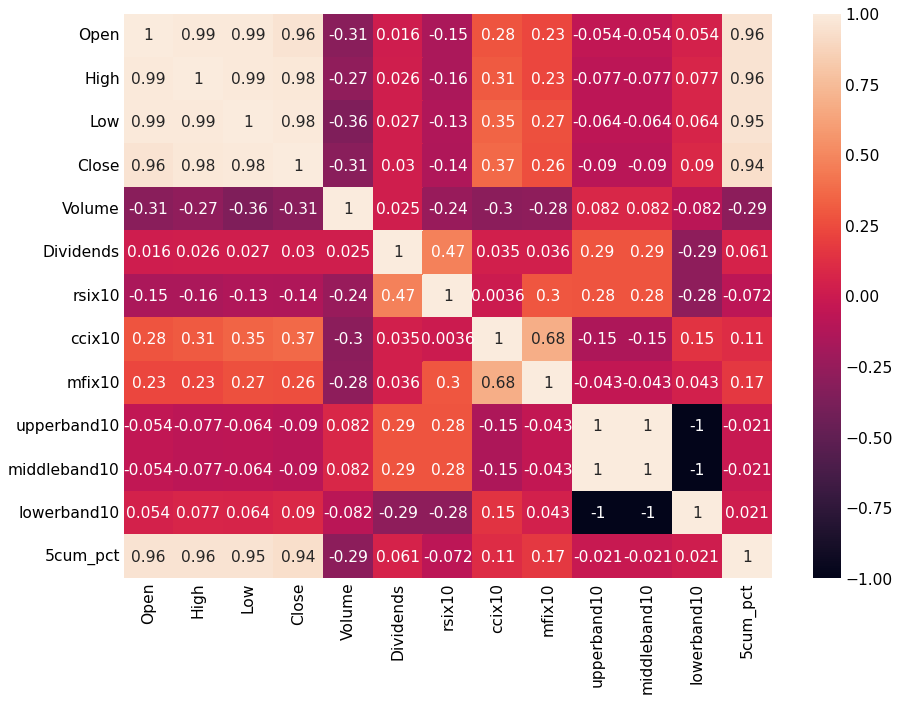

In [170]:
 
plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show  # show the plot

In [171]:
aapl.drop(['Volume'],axis=1)

,Open,High,Low,Close,Dividends,rsix10,ccix10,mfix10,upperband10,middleband10,lowerband10,5cum_pct
Date,,,,,,,,,,,,
2022-01-04,182.130025,182.439174,178.629624,179.208038,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,179.118279,179.676743,174.161884,174.441116,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,172.227210,174.820098,171.170114,171.529129,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07,172.416684,173.663262,170.561776,171.698654,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-10,168.617111,172.027746,167.709599,171.718597,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-06,147.029999,148.570007,144.899994,146.139999,0.0,47.368421,33.088255,70.786326,0.0,0.0,0.0,-0.688898
2022-06-07,144.350006,149.000000,144.100006,148.710007,0.0,47.368421,21.938096,61.246931,0.0,0.0,0.0,-0.689771
2022-06-08,148.580002,149.869995,147.460007,147.960007,0.0,47.368421,62.136238,71.441476,0.0,0.0,0.0,-0.694814


## Building and none visual evaluations of models

### train test split of series data

In [175]:

con=aapl.shape[0]
con60=con-30

X_train = scale(aapl.iloc[20:con60,6:14].values)
X_test = scale(aapl.iloc[(con60-10):con,6:14].values)[:20,:]

y_train = aapl.shift(-5).iloc[20:con60,-1].values
y_test = aapl.shift(-5).iloc[(con60-1):con,-1].values[:20]

X_pred= scale(aapl.iloc[(con60-10):con,7:10].values)[:20,:]

### Linear model

In [176]:
lm_model = LinearRegression()

In [177]:
lm_model.fit(X_train,y_train)

LinearRegression()

In [178]:
pred = lm_model.predict(X_test)

In [179]:
print(lm_model.score(X_train,y_train))

0.612712086209712


In [180]:
print(lm_model.score(X_test,y_test))
print(mean_squared_error(y_test,pred))

-8.102398710886673
0.3768523469421181


### SVM model

In [181]:
sv_model = SVR(kernel='rbf')

In [182]:
sv_model.fit(X_test,y_test)

SVR()

In [183]:
predsv = sv_model.predict(X_test)

In [184]:
print(sv_model.score(X_test,y_test))
print(mean_squared_error(y_test,predsv))

0.8328570179563661
0.006919958909590765


### KNN model

In [185]:
kn_model = KNeighborsRegressor(n_neighbors=5)

In [186]:
kn_model.fit(X_train,y_train)

KNeighborsRegressor()

In [187]:
predkn = kn_model.predict(X_test)

In [188]:
predkntr = kn_model.predict(X_train)

In [189]:
print(kn_model.score(X_test,y_test))
print(mean_squared_error(y_test,predkn))

-7.670012997588644
0.35895095896559304


### RandomForest model

In [190]:
R=rfr(n_estimators=1000)
R.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000)

In [191]:
predr=R.predict(X_test)
print(R.score(X_test,y_test))
print(mean_squared_error(y_test,predr))


-8.072591815326412
0.37561829876386066


### Bayesian models

In [192]:

r1 = LinearRegression()
r2 = rfr(n_estimators=1000, random_state=1)
er = VotingRegressor([('lr', r1), ('rf', r2)])
er_pred = er.fit(X_train, y_train).predict(X_test)
print(mean_squared_error(y_test,er_pred))
print(er.score(X_test, y_test))

#print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

0.37397442916907714
-8.032886194273928


In [193]:
import random
>>> from sklearn.gaussian_process import GaussianProcessRegressor
>>> from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

>>> kernel = RBF() + 2.2# = DotProduct() + WhiteKernel()
random.seed(9)
dy =  0.5 + 1.0 * np.random.random(y_train.shape)
noise = np.random.normal(0, dy)


# Instantiate a Gaussian Process model
gpr = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10,random_state=0).fit(X_train,y_train)
#>>> gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train, y_train)
print(gpr.score(X_test, y_test))

gpred=gpr.predict(X_test)

print(mean_squared_error(y_test,gpred))

-6.961209751265762
0.32960548911955173


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


### XGBoost model

In [194]:
import xgboost

from sklearn.model_selection import cross_validate, GridSearchCV 
from sklearn import metrics   #Additional scklearn functions



#setting grid of selected parameters for iteration

params_grid = {
    'learning_rate':[0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3],
    'gamma':[0,1,2,3,5,7,9],
    'max_depth':[4,5,6,7,8,9],
    'n_estimators':[10,30,50,70,90,100]
}



num_boost_round = 999



In [195]:
from xgboost.sklearn import XGBRegressor


xgb = XGBRegressor()
clf = GridSearchCV(estimator=xgb, param_grid=params_grid, return_train_score=True, verbose=1, cv=2)

clf.fit(X_train, y_train)

#results dataframe
df = pd.DataFrame(clf.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

Fitting 2 folds for each of 2016 candidates, totalling 4032 fits
[18:17:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:17:53] WARNING: /workspace/src/objective/r

In [196]:

print(clf.score(X_test,y_test))
print(mean_squared_error(y_test,test_predictions))

-8.747987948340018
0.4035806662590783


In [197]:
predxgb=clf.predict(X_test)
print(clf.score(X_test,y_test))
print(mean_squared_error(y_test,predxgb))

-8.747987948340018
0.4035806662590783


# MLP NN

In [198]:
NN = MLPRegressor()
NN.fit(X_train,y_train)

MLPRegressor()

In [199]:
prednn=NN.predict(X_test)
print(NN.score(X_test,y_test))
print(mean_squared_error(y_test,prednn))


-7.7432697877477725
0.361983895027589


#### the randomforest model is th most superior!

## Building representations for each state in time

#### we do this by clustering the indicators in 5 theoretical states:
    -- mono
    -- up
    -- up steep
    -- down
    -- down steep

In [200]:
from sklearn.cluster import KMeans

In [201]:
kmeans = KMeans(n_clusters=2) # You want cluster the passenger records into 2: Survived or Not survived
kmeans.fit(X_train)

KMeans(n_clusters=2)

In [202]:
predclutr=kmeans.predict(X_train)

In [203]:
predclu=kmeans.predict(X_test)

In [206]:

y_trainv = aapl.iloc[20:con60,-1].values
y_testv = aapl.iloc[(con60-1):con,-1].values[:56]

In [207]:
kmeansv = KMeans(n_clusters=2) # You want cluster the passenger records into 2: Survived or Not survived
kmeansv.fit(y_trainv.reshape(-1,1))

KMeans(n_clusters=2)

In [208]:
predclutrv=kmeansv.predict(y_trainv.reshape(-1,1))
predcluv=kmeansv.predict(y_testv.reshape(-1,1))

Prime allocation

In [209]:
 
t =[]
kx=range(1,61)
R=pd.DataFrame(predcluv).rolling(2).sum()
for k, I in enumerate(R):
  if (I/(I+1) % 2) == 0 or (I/t % 2) == 0:
      t = I;
      break

## Visual Evaluation

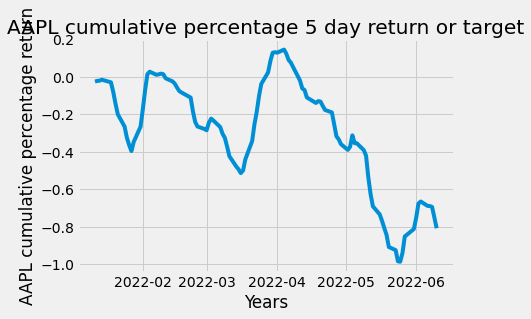

In [210]:
plt.plot(aapl['5cum_pct'].dropna())
plt.title('AAPL cumulative percentage 5 day return or target')
plt.xlabel('Years')
plt.ylabel('AAPL cumulative percentage return')
plt.show()

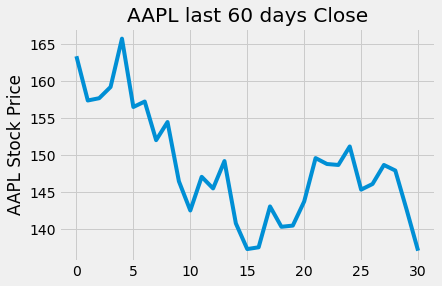

In [211]:
plt.plot(aapl.iloc[con60-1:,3].values)
plt.title('AAPL last 60 days Close')
plt.ylabel('AAPL Stock Price')
plt.show()

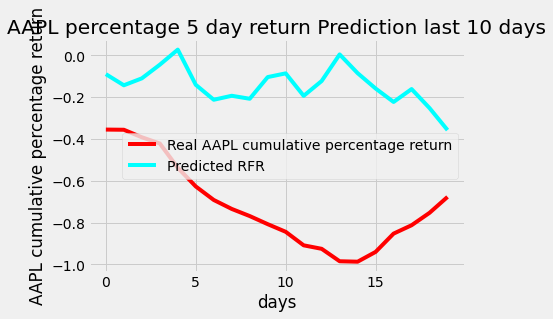

In [212]:
# Visualising the results

plt.plot(y_test, color = 'red', label = 'Real AAPL cumulative percentage return')
#plt.plot(predx, color = 'blue', label = 'Predicted XGB')
#plt.plot(, color = 'green', label = 'Predicted KNN')
plt.plot(pred, color = 'cyan', label = 'Predicted RFR')
plt.title('AAPL percentage 5 day return Prediction last 10 days')
plt.xlabel('days')
plt.ylabel('AAPL cumulative percentage return')
plt.legend()
plt.show()

In [213]:
(X_pred)


array([[-0.19644639, -1.58117137, -0.57735027],
       [-0.6935138 , -1.53330628, -0.57735027],
       [-0.3486461 , -1.64936211, -0.57735027],
       [ 0.25296232, -0.77225244, -0.57735027],
       [ 0.95866856,  0.34108329, -0.57735027],
       [-0.80161943,  0.31649031, -0.57735027],
       [-1.52621338,  0.22996519, -0.57735027],
       [-1.12008478,  0.12006204, -0.57735027],
       [-0.96249559, -0.84091225, -0.57735027],
       [ 0.16148655, -0.46270446, -0.57735027],
       [ 0.28563696,  0.64172652, -0.57735027],
       [-0.7599412 ,  0.39665053, -0.57735027],
       [-0.05069505,  0.47904922, -0.57735027],
       [ 1.12938588,  0.64880035, -0.57735027],
       [ 0.40681415, -0.32162151, -0.57735027],
       [-0.29325237, -0.41820927,  1.73205081],
       [-0.95979288, -0.52139459,  1.73205081],
       [-0.31480287,  0.32887535,  1.73205081],
       [-0.93591307,  0.14359735,  1.73205081],
       [-1.67088223, -0.96628773,  1.73205081]])

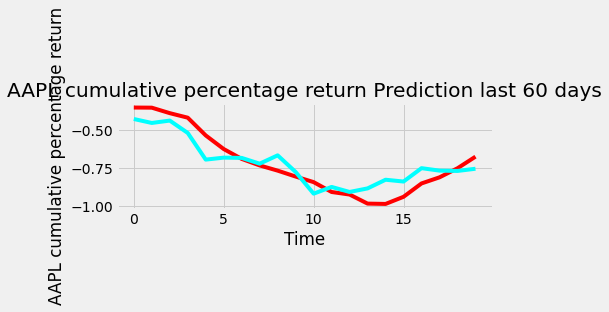

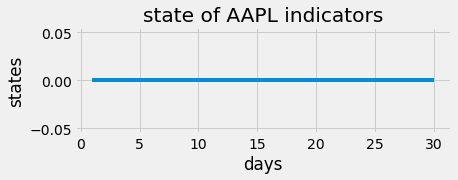

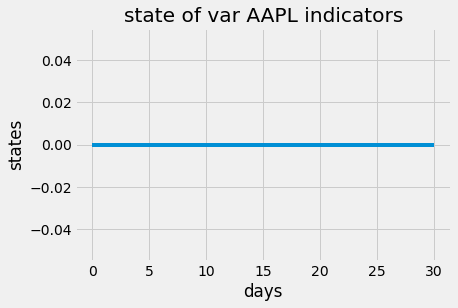

In [216]:
# Visualising the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_test, color = 'red', label = 'Real AAPL Stock Price')
plt.plot(predsv, color = 'cyan', label = 'Predicted SVM')
plt.title('AAPL cumulative percentage return Prediction last 60 days')
plt.xlabel('Time')
plt.ylabel('AAPL cumulative percentage return')
plt.show()
plt.subplot(2,1,2)
plt.plot(R[0:])
plt.title('state of AAPL indicators')
plt.xlabel('days')
plt.ylabel('states')
plt.show()
plt.plot(predcluv) 
plt.title('state of var AAPL indicators')
plt.xlabel('days')
plt.ylabel('states')
plt.show()

here we see that the SVM has performed well but our clustering has not performed.

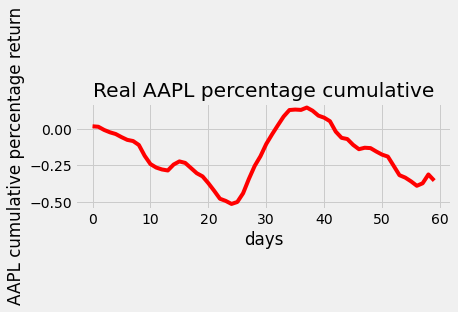

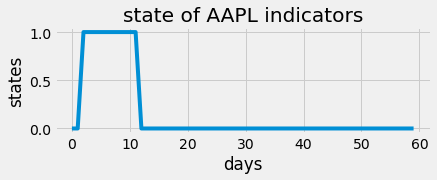

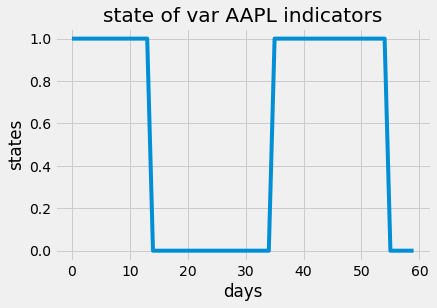

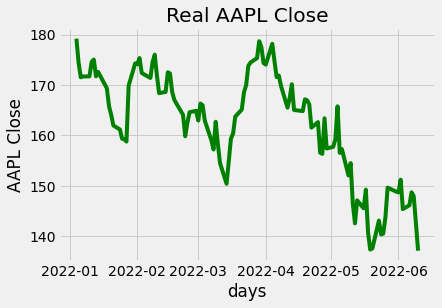

In [215]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_train, color = 'red', label = 'Real AAPL cumulative percentage return')
plt.title('Real AAPL percentage cumulative')
plt.xlabel('days')
plt.ylabel('AAPL cumulative percentage return')
#plt.ylim(-8925,-8900)
#plt.xlim(350,600)
plt.show()

plt.subplot(2,1,2)
plt.plot(predclutr)
plt.title('state of AAPL indicators')
#plt.xlim(350,600)
plt.xlabel('days')
plt.ylabel('states')
plt.show()

#plt.subplot(2,1,2)
plt.plot(predclutrv)
plt.title('state of var AAPL indicators')
#plt.xlim(350,600)
plt.xlabel('days')
plt.ylabel('states')
plt.show()

#plt.figure()
#plt.subplot(2,2,1)
plt.plot(aapl['Close'], color = 'green', label = 'Real AAPL Close')
plt.title('Real AAPL Close')
plt.xlabel('days')
plt.ylabel('AAPL Close')
#plt.ylim(-8925,-8900)
#plt.xlim(350,600)
plt.show()

#### what we can see from these graphs is how the randomforest model did on unknown data, and that the state representations captured the rising trend or when to strike in "cumulative 5 days percentage return" although due the randomness of picking specific states. all in all one can call this whole exercise a success answering all our questions.